## BLAKE3
with minimal optimizations, following the reference implementation: 
https://github.com/BLAKE3-team/BLAKE3/blob/master/reference_impl/reference_impl.rs

In [2]:
# Converts an integer type to a bytes type
def int_to_byte(integer):
    return integer.to_bytes(4,byteorder='little')

def byte_to_int(word):
    if isinstance(word,bytes):  
        return int.from_bytes(word,'little')
    return word

In [3]:
# Constants
# Initialization Vector
IV = [0x6A09E667, 0xBB67AE85, 0x3C6EF372, 0xA54FF53A, 
      0x510E527F, 0x9B05688C, 0x1F83D9AB, 0x5BE0CD19]
# Permutation
SIGMA = (2, 6, 3, 10, 7, 0, 4, 13, 1, 11, 12, 5, 9, 14, 15, 8)

# n//8 bytes, all ones. Bitwise 'and' is effectively same as mod 2^n
MASK32 = 0xFFFFFFFF
MASK64 = 0xFFFFFFFFFFFFFFFF


# Possible values for the flag d
CHUNK_START = 2**0
CHUNK_END   = 2**1
PARENT      = 2**2
ROOT        = 2**3

In [4]:
# Utility functions:

# Bitwise rotations:
def rotateR(bitstring, shift, bitlength=32):
    return ((bitstring >> shift) | (bitstring << (bitlength - shift)))& MASK32
def rotateL(bitstring, shift, bitlength=32):
    return ((bitstring << shift) | (bitstring >> (bitlength - shift)))& MASK32

def add32(a,b):
    """Addition modulo 2^32"""
    return (a+b) & MASK32

def permutate(m):
    permutation = [ m[SIGMA[i]] for i in range(16) ]
    m = permutation

### Compression

In [5]:


def validate_inputs(h, m, t, b, d):
    for i in range(8):
        h[i] = byte_to_int(h[i])&MASK32
        m[i] = byte_to_int(m[i])&MASK32
        m[8+i]= byte_to_int(m[2*i])&MASK32
    if isinstance(t,int):
        t= [t & MASK32, (t>>32) & MASK32]
    b=b&MASK32
    d=d&MASK32
    return h, m, t, b, d


def init_state(h, t, b, d):
    """
    V= [ h0,  h1,  h2,  h3  ]
       [ h4,  h5,  h6,  h7  ]
       [ IV0, IV1, IV2, IV3 ]
       [ t0,  t1,  b,   d   ]
    """
    
    V = [h[0],  h[1],  h[2],  h[3],
         h[4],  h[5],  h[6],  h[7],
         IV[0], IV[1], IV[2], IV[3],
         t[0],  t[1],  b,     d
        ]
    return V

def G(V, Va, Vb, Vc, Vd, m_1, m_2):
    """Mixing function. Transforms V"""
    
    a = V[Va]
    b = V[Vb]
    c = V[Vc]
    d = V[Vd]

    
    a = add32( add32(a, b), m_1 )
    d = rotateR(d^a, 16) 
    c = add32(c, d)
    b = rotateR(b^c, 12)
    a = add32( add32(a, b), m_2 )
    d = rotateR(d^a, 8) 
    c = add32(c, d)
    b = rotateR(b^c, 7)
    
    V[Va] = a
    V[Vb] = b
    V[Vc] = c
    V[Vd] = d


def round(V, m):
    """One iteration of a round. Transforms V""" 
    
    # Columns, can all be done parallel
    G(V, 0, 4,  8, 12, m[0], m[1])
    G(V, 1, 5,  9, 13, m[2], m[3])
    G(V, 2, 6, 10, 14, m[4], m[5])
    G(V, 3, 7, 11, 15, m[6], m[7])
    
    # Diagonals, can all be done parallel
    G(V, 0, 5, 10, 15, m[8],  m[9] )
    G(V, 1, 6, 11, 12, m[10], m[11])
    G(V, 2, 7,  8, 13, m[12], m[13])
    G(V, 3, 4,  9, 14, m[14], m[15])


def _compress(h, m, t=0, b=0x00000000, d=0x00000000):
    """
    Compression function:
        Inputs:
            h = [h0,...,h7] - Chaining value. Array of 8 bytestrings of 4 bytes
            m = [m0,...,h15] - Message data block. Array of 16 bytestrings of 4 bytes
            t = [t0,t1] - Counter. Array of 2 bytestrings of 4 bytes
            b - Number of input bytes in the block. 4 bytes
            d - Domain separation flag. 4 bytes (bitfield, with each individual flag consisting of a power of 2.) 
    
        Possible values of d:
           CHUNK_START 2**0
           CHUNK_END 2**1
           PARENT 2**2
           ROOT 2**3
           KEYED_HASH 2**4
           DERIVE_KEY_CONTEXT 2**5
           DERIVE_KEY_MATERIAL 2**6
    """
    
    
    # Intialization: 
    #-------------------------------------------------------------------------#
    h, m, t, b, d= validate_inputs(h, m, t, b, d)
    V = init_state(h,t,b,d)
    #-------------------------------------------------------------------------#
    
    
    # Compression rounds
    #-------------------------------------------------------------------------#
    for r in range(6):
        round(V, m)  # Changes V
        permutate(m) # Changes m
    round(V,m) # The last, 7th, round is without a new permutation.
    #-------------------------------------------------------------------------#
   
    
    # Finalization:
    #-------------------------------------------------------------------------#  
    
    # Output is of shape
    # [V0^V8, V1^V9, V2^V10, V3^V11, V4^V12, V5^V13, V6^V14, V7^V15,
    #  h0^V8, h1^V9, h2^V10, h3^V11, h4^V12, h5^V13, h6^V14, h7^V15]
    for i in range(8):
        V[i] = V[i]^V[i+8]
        V[i+8] = h[i]^V[8+i]
        h_new = [int_to_byte(V[i]) for i in range(16)] #Changing to bytes for output TODO optimize into otuput
    return h_new


In [6]:
import numpy as np

h = IV
t=[0x00000000,0x00000000]
b=0
d=0
V = init_state(h, t, b, d)
m=[0x00000000,0x00000000]
print(np.reshape(V,(4,4)))

G(V,0, 4,  8, 12, m[0], m[1])
print(np.reshape(V,(4,4)))

[[1779033703 3144134277 1013904242 2773480762]
 [1359893119 2600822924  528734635 1541459225]
 [1779033703 3144134277 1013904242 2773480762]
 [         0          0          0          0]]
[[3945232597 3144134277 1013904242 2773480762]
 [1518442169 2600822924  528734635 1541459225]
 [1891918658 3144134277 1013904242 2773480762]
 [3453206979          0          0          0]]


#### Util class:

In [7]:
class Output:
    '''This class is soley for holding values'''
    def __init__(self, chaining_value, m, counter, block_len, flags):
        self.h  = chaining_value
        self.m  = m
        self.t  = counter
        self.b  = block_len
        self.d = flags
    
    def comp_params(self):
        h, m, t, b, d = validate_inputs( self.h, self.m, self.t, self.b, self.d)
        return h, m, t, b, d
    
    def root_output_bytes(self, output_length):
        output_block_counter = 0& MASK64
        h, m, t, b, d = self.comp_params()
        d = d | ROOT
        
        output = []
        current_output_len = 0
        
        # Iterate the _compress function and add it to the output 
        # until len(output) < output_length
        for block_index in range(0,output_length,64):
            # The repeated root compressions differ only in the value of t
            t = output_block_counter
            next_block = _compress(h, m, t, b, d)
            
            output += next_block
            output_block_counter = (output_block_counter+1) & MASK64
            current_output_len += 64
        
        # Makes sure the output is not longer than desired. Note that it can not be smaller.
        output_bytestring = b''
        for word in output:
            output_bytestring += word
        
        return output_bytestring[:output_length] 
            

### Processing a chunk

In [8]:
import struct
# Expects data of type datablock=b'contentsofarandomfileofrandomlength'
def block_to_words(datablock):
    return list( struct.unpack('<16L',datablock) ) # Length of datablock is *always* 64  
    

In [9]:
class Chunk:

    def __init__(self, cv, chunk_counter, flags):
        self.chaining_value    = cv
        self.chunk_counter     = chunk_counter
        self.block_buffer      = b''
        self.block_buffer_len  = 0
        self.blocks_compressed = 0
        self.flags             = flags
        
    
    def len(self):
        return 64 * self.blocks_compressed + self.block_buffer_len
    
    # If the current block is the first, returns the CHUNK_START flag.
    def start_flag(self):
        if self.blocks_compressed == 0:
            return CHUNK_START
        return 0
        
    def len(self):
        return 64*self.blocks_compressed + self.block_buffer_len
    
    def update(self, data):
    
        # If there is more input then this compression is not CHUNK_END.
        while data:
        
            # If the block buffer is full, compress it and clear it. 
            if self.block_buffer_len >= 64:
                cv = self.chaining_value
                m = block_to_words(self.block_buffer[:64])
                t = self.chunk_counter
                b = 64
                d = self.flags | self.start_flag()
                self.chaining_value = _compress(cv, m, t, b, d)[:8]
                
                self.blocks_compressed += 1
                self.block_buffer = self.block_buffer[64:]
                self.block_buffer_len = self.block_buffer_len - 64
            
            # Copy input bytes into the block buffer.
            room_in_block = 64 - self.block_buffer_len
            take = min(room_in_block, len(data))
            self.block_buffer += data[ :take]
            self.block_buffer_len += take
            
            data = data[take: ]
            
            
        

    def output(self):
        # Padding
        if self.block_buffer_len < 64:
            zeroes64 = b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
            padding = zeroes64[self.block_buffer_len:64]
            self.block_buffer += padding
            
        m = block_to_words(self.block_buffer[:64])
        cv = self.chaining_value
        b = self.block_buffer_len 
        t = self.chunk_counter
        d = self.flags | self.start_flag() | CHUNK_END
        return Output(cv,m,t,b,d)
        

#### Tree structure and Chuncks

In [10]:
def parent_output(left_child_cv, right_child_cv,  h, flags):
    m = left_child_cv[:] + right_child_cv[:]
    t = 0                # Counter 't' is always 0 for parent nodes
    b = 64               # Number of input bits in block 'b' is always 64 for parent nodes
    d = PARENT | flags   # Parent nodes also set the PARENT flag
    return Output(h, left_child_cv[:] + right_child_cv[:],t,b,d)


# Combines the chaining values of its two children by compressing them
# Used to reduce memory required for the tree (in f-n add_chunk_chaining_value)
def parent_cv(left_child_cv, right_child_cv,  h, flags):
    h, m, t, b, d = parent_output(left_child_cv, right_child_cv, h, flags).comp_params()
    
    # Only taking the first 8 values from the array of 16. This way we can use it as a new chaining value
    return _compress(h, m, t, b, d)[:8] 




In [11]:
class BLAKE:
    def __init__(self):
        self.chaining_value = IV
        self.cv_stack = []
        self.cv_stack_len = 0
        self.flags = 0
        self.chunk_state = Chunk(IV,0,0)
        
    # Stack functions
    def push(self, chaining_value):
        self.cv_stack.append(chaining_value)
        self.cv_stack_len += 1
    def pop(self):
        self.cv_stack_len -= 1
        h = self.cv_stack[-1]
        self.cv_stack = self.cv_stack[:-1]
        return h

    
    # Adds a hash value of a chunk to the tree. 
    def add_chunk(self, new_cv, total_chunks):
        # This chunk might complete some subtrees. For each completed subtree,
        # its left child will be the current top entry in the CV stack, and
        # its right child will be the current value of `new_cv`. Pop each left
        # child off the stack, merge it with `new_cv`, and overwrite `new_cv`
        # with the result. After all these merges, push the final value of
        # `new_cv` onto the stack. The number of completed subtrees is given
        # by the number of trailing 0-bits in the new total number of chunks.
        while total_chunks & 1 == 0:
            new_cv = parent_cv(self.pop(), new_cv, self.chaining_value, self.flags)
            total_chunks = total_chunks >> 1
        self.push(new_cv)
    
    
    
    # Add input to the hash state. This can be called any number of times.
    def update(self, data):
        
        # If there is more data, then the current chunk is not ROOT
        while data:
        
            # If the current chunk is complete (has 1024 bytes), finalize it and reset the chunk state.
            if self.chunk_state.len() == 1024:
                # Compress output to get a cv for the next chunk
                h, m, t, b, d = self.chunk_state.output().comp_params()
                chunk_cv = _compress( h, m, t, b, d  )[:8]
                total_chunks = self.chunk_state.chunk_counter + 1 
                # Add the result into the tree
                self.add_chunk(chunk_cv, total_chunks)
                # Initialize the next chunk
                self.chunk_state = Chunk(self.chaining_value, total_chunks, self.flags)
            
            # Compress input bytes into the current chunk state.
            room_in_chunk = 1024 - self.chunk_state.len()
            chunkdata = data[ :room_in_chunk] 
            #print(type(chunkdata))
            datalen = len(chunkdata) # equiv to min(room_in_chunk, len(data)), but faster
            self.chunk_state.update(chunkdata)  
            data = data[datalen: ]
       


    # Finalize the hash and write any number of output bytes.
    def digest(self, output_length = 64): 
        # Starting with the Output from the current chunk, compute all the
        # parent chaining values along the right edge of the tree, until we
        # have the root Output.
        output = self.chunk_state.output()
        parent_nodes_remaining = self.cv_stack_len
        
        while parent_nodes_remaining > 0:
            parent_nodes_remaining -= 1
            
            left_child_cv = self.cv_stack[parent_nodes_remaining]
            h, m, t, b, d = output.comp_params()
            right_child_cv = _compress(h, m, t, b, d)[:8]
            h = self.chaining_value
            flags = PARENT | self.flags
            
            output = parent_output(left_child_cv, right_child_cv,  h, flags)
        

        return output.root_output_bytes(output_length)
    

# Testing: 

In [12]:
# Test vector:
# The input is filled with a repeating sequence of 251 bytes: 0, 1, 2, ..., 249, 250, 0, 1, ..., and so on.
test_vector = b''
max_input_len = 1_000
for i in range(max_input_len):
    test_vector += (i%251).to_bytes(1,'little')

# The hash values from actual BLAKE with the above inputs
test_values = {
    0: "af1349b9f5f9a1a6a0404dea36dcc9499bcb25c9adc112b7cc9a93cae41f3262e00f03e7b69af26b7faaf09fcd333050338ddfe085b8cc869ca98b206c08243a26f5487789e8f660afe6c99ef9e0c52b92e7393024a80459cf91f476f9ffdbda7001c22e159b402631f277ca96f2defdf1078282314e763699a31c5363165421cce14d",
    1: "2d3adedff11b61f14c886e35afa036736dcd87a74d27b5c1510225d0f592e213c3a6cb8bf623e20cdb535f8d1a5ffb86342d9c0b64aca3bce1d31f60adfa137b358ad4d79f97b47c3d5e79f179df87a3b9776ef8325f8329886ba42f07fb138bb502f4081cbcec3195c5871e6c23e2cc97d3c69a613eba131e5f1351f3f1da786545e5",
    2: "7b7015bb92cf0b318037702a6cdd81dee41224f734684c2c122cd6359cb1ee63d8386b22e2ddc05836b7c1bb693d92af006deb5ffbc4c70fb44d0195d0c6f252faac61659ef86523aa16517f87cb5f1340e723756ab65efb2f91964e14391de2a432263a6faf1d146937b35a33621c12d00be8223a7f1919cec0acd12097ff3ab00ab1",
    3: "e1be4d7a8ab5560aa4199eea339849ba8e293d55ca0a81006726d184519e647f5b49b82f805a538c68915c1ae8035c900fd1d4b13902920fd05e1450822f36de9454b7e9996de4900c8e723512883f93f4345f8a58bfe64ee38d3ad71ab027765d25cdd0e448328a8e7a683b9a6af8b0af94fa09010d9186890b096a08471e4230a134",
    4: "f30f5ab28fe047904037f77b6da4fea1e27241c5d132638d8bedce9d40494f328f603ba4564453e06cdcee6cbe728a4519bbe6f0d41e8a14b5b225174a566dbfa61b56afb1e452dc08c804f8c3143c9e2cc4a31bb738bf8c1917b55830c6e65797211701dc0b98daa1faeaa6ee9e56ab606ce03a1a881e8f14e87a4acf4646272cfd12",
    5: "b40b44dfd97e7a84a996a91af8b85188c66c126940ba7aad2e7ae6b385402aa2ebcfdac6c5d32c31209e1f81a454751280db64942ce395104e1e4eaca62607de1c2ca748251754ea5bbe8c20150e7f47efd57012c63b3c6a6632dc1c7cd15f3e1c999904037d60fac2eb9397f2adbe458d7f264e64f1e73aa927b30988e2aed2f03620",
    6: "06c4e8ffb6872fad96f9aaca5eee1553eb62aed0ad7198cef42e87f6a616c844611a30c4e4f37fe2fe23c0883cde5cf7059d88b657c7ed2087e3d210925ede716435d6d5d82597a1e52b9553919e804f5656278bd739880692c94bff2824d8e0b48cac1d24682699e4883389dc4f2faa2eb3b4db6e39debd5061ff3609916f3e07529a",
    7: "3f8770f387faad08faa9d8414e9f449ac68e6ff0417f673f602a646a891419fe66036ef6e6d1a8f54baa9fed1fc11c77cfb9cff65bae915045027046ebe0c01bf5a941f3bb0f73791d3fc0b84370f9f30af0cd5b0fc334dd61f70feb60dad785f070fef1f343ed933b49a5ca0d16a503f599a365a4296739248b28d1a20b0e2cc8975c",
    8: "2351207d04fc16ade43ccab08600939c7c1fa70a5c0aaca76063d04c3228eaeb725d6d46ceed8f785ab9f2f9b06acfe398c6699c6129da084cb531177445a682894f9685eaf836999221d17c9a64a3a057000524cd2823986db378b074290a1a9b93a22e135ed2c14c7e20c6d045cd00b903400374126676ea78874d79f2dd7883cf5c",
    63: "e9bc37a594daad83be9470df7f7b3798297c3d834ce80ba85d6e207627b7db7b1197012b1e7d9af4d7cb7bdd1f3bb49a90a9b5dec3ea2bbc6eaebce77f4e470cbf4687093b5352f04e4a4570fba233164e6acc36900e35d185886a827f7ea9bdc1e5c3ce88b095a200e62c10c043b3e9bc6cb9b6ac4dfa51794b02ace9f98779040755",
    64: "4eed7141ea4a5cd4b788606bd23f46e212af9cacebacdc7d1f4c6dc7f2511b98fc9cc56cb831ffe33ea8e7e1d1df09b26efd2767670066aa82d023b1dfe8ab1b2b7fbb5b97592d46ffe3e05a6a9b592e2949c74160e4674301bc3f97e04903f8c6cf95b863174c33228924cdef7ae47559b10b294acd660666c4538833582b43f82d74",
    65: "de1e5fa0be70df6d2be8fffd0e99ceaa8eb6e8c93a63f2d8d1c30ecb6b263dee0e16e0a4749d6811dd1d6d1265c29729b1b75a9ac346cf93f0e1d7296dfcfd4313b3a227faaaaf7757cc95b4e87a49be3b8a270a12020233509b1c3632b3485eef309d0abc4a4a696c9decc6e90454b53b000f456a3f10079072baaf7a981653221f2c",
    127: "d81293fda863f008c09e92fc382a81f5a0b4a1251cba1634016a0f86a6bd640de3137d477156d1fde56b0cf36f8ef18b44b2d79897bece12227539ac9ae0a5119da47644d934d26e74dc316145dcb8bb69ac3f2e05c242dd6ee06484fcb0e956dc44355b452c5e2bbb5e2b66e99f5dd443d0cbcaaafd4beebaed24ae2f8bb672bcef78",
    128: "f17e570564b26578c33bb7f44643f539624b05df1a76c81f30acd548c44b45efa69faba091427f9c5c4caa873aa07828651f19c55bad85c47d1368b11c6fd99e47ecba5820a0325984d74fe3e4058494ca12e3f1d3293d0010a9722f7dee64f71246f75e9361f44cc8e214a100650db1313ff76a9f93ec6e84edb7add1cb4a95019b0c",
    129: "683aaae9f3c5ba37eaaf072aed0f9e30bac0865137bae68b1fde4ca2aebdcb12f96ffa7b36dd78ba321be7e842d364a62a42e3746681c8bace18a4a8a79649285c7127bf8febf125be9de39586d251f0d41da20980b70d35e3dac0eee59e468a894fa7e6a07129aaad09855f6ad4801512a116ba2b7841e6cfc99ad77594a8f2d181a7",
    1023: "10108970eeda3eb932baac1428c7a2163b0e924c9a9e25b35bba72b28f70bd11a182d27a591b05592b15607500e1e8dd56bc6c7fc063715b7a1d737df5bad3339c56778957d870eb9717b57ea3d9fb68d1b55127bba6a906a4a24bbd5acb2d123a37b28f9e9a81bbaae360d58f85e5fc9d75f7c370a0cc09b6522d9c8d822f2f28f485",
    1024: "42214739f095a406f3fc83deb889744ac00df831c10daa55189b5d121c855af71cf8107265ecdaf8505b95d8fcec83a98a6a96ea5109d2c179c47a387ffbb404756f6eeae7883b446b70ebb144527c2075ab8ab204c0086bb22b7c93d465efc57f8d917f0b385c6df265e77003b85102967486ed57db5c5ca170ba441427ed9afa684e",
    1025: "d00278ae47eb27b34faecf67b4fe263f82d5412916c1ffd97c8cb7fb814b8444f4c4a22b4b399155358a994e52bf255de60035742ec71bd08ac275a1b51cc6bfe332b0ef84b409108cda080e6269ed4b3e2c3f7d722aa4cdc98d16deb554e5627be8f955c98e1d5f9565a9194cad0c4285f93700062d9595adb992ae68ff12800ab67a",
    2048: "e776b6028c7cd22a4d0ba182a8bf62205d2ef576467e838ed6f2529b85fba24a9a60bf80001410ec9eea6698cd537939fad4749edd484cb541aced55cd9bf54764d063f23f6f1e32e12958ba5cfeb1bf618ad094266d4fc3c968c2088f677454c288c67ba0dba337b9d91c7e1ba586dc9a5bc2d5e90c14f53a8863ac75655461cea8f9",
    2049: "5f4d72f40d7a5f82b15ca2b2e44b1de3c2ef86c426c95c1af0b687952256303096de31d71d74103403822a2e0bc1eb193e7aecc9643a76b7bbc0c9f9c52e8783aae98764ca468962b5c2ec92f0c74eb5448d519713e09413719431c802f948dd5d90425a4ecdadece9eb178d80f26efccae630734dff63340285adec2aed3b51073ad3",
    3072: "b98cb0ff3623be03326b373de6b9095218513e64f1ee2edd2525c7ad1e5cffd29a3f6b0b978d6608335c09dc94ccf682f9951cdfc501bfe47b9c9189a6fc7b404d120258506341a6d802857322fbd20d3e5dae05b95c88793fa83db1cb08e7d8008d1599b6209d78336e24839724c191b2a52a80448306e0daa84a3fdb566661a37e11",
    3073: "7124b49501012f81cc7f11ca069ec9226cecb8a2c850cfe644e327d22d3e1cd39a27ae3b79d68d89da9bf25bc27139ae65a324918a5f9b7828181e52cf373c84f35b639b7fccbb985b6f2fa56aea0c18f531203497b8bbd3a07ceb5926f1cab74d14bd66486d9a91eba99059a98bd1cd25876b2af5a76c3e9eed554ed72ea952b603bf",
    4096: "015094013f57a5277b59d8475c0501042c0b642e531b0a1c8f58d2163229e9690289e9409ddb1b99768eafe1623da896faf7e1114bebeadc1be30829b6f8af707d85c298f4f0ff4d9438aef948335612ae921e76d411c3a9111df62d27eaf871959ae0062b5492a0feb98ef3ed4af277f5395172dbe5c311918ea0074ce0036454f620",
    4097: "9b4052b38f1c5fc8b1f9ff7ac7b27cd242487b3d890d15c96a1c25b8aa0fb99505f91b0b5600a11251652eacfa9497b31cd3c409ce2e45cfe6c0a016967316c426bd26f619eab5d70af9a418b845c608840390f361630bd497b1ab44019316357c61dbe091ce72fc16dc340ac3d6e009e050b3adac4b5b2c92e722cffdc46501531956",
    5120: "9cadc15fed8b5d854562b26a9536d9707cadeda9b143978f319ab34230535833acc61c8fdc114a2010ce8038c853e121e1544985133fccdd0a2d507e8e615e611e9a0ba4f47915f49e53d721816a9198e8b30f12d20ec3689989175f1bf7a300eee0d9321fad8da232ece6efb8e9fd81b42ad161f6b9550a069e66b11b40487a5f5059",
    5121: "628bd2cb2004694adaab7bbd778a25df25c47b9d4155a55f8fbd79f2fe154cff96adaab0613a6146cdaabe498c3a94e529d3fc1da2bd08edf54ed64d40dcd6777647eac51d8277d70219a9694334a68bc8f0f23e20b0ff70ada6f844542dfa32cd4204ca1846ef76d811cdb296f65e260227f477aa7aa008bac878f72257484f2b6c95",
    6144: "3e2e5b74e048f3add6d21faab3f83aa44d3b2278afb83b80b3c35164ebeca2054d742022da6fdda444ebc384b04a54c3ac5839b49da7d39f6d8a9db03deab32aade156c1c0311e9b3435cde0ddba0dce7b26a376cad121294b689193508dd63151603c6ddb866ad16c2ee41585d1633a2cea093bea714f4c5d6b903522045b20395c83",
    6145: "f1323a8631446cc50536a9f705ee5cb619424d46887f3c376c695b70e0f0507f18a2cfdd73c6e39dd75ce7c1c6e3ef238fd54465f053b25d21044ccb2093beb015015532b108313b5829c3621ce324b8e14229091b7c93f32db2e4e63126a377d2a63a3597997d4f1cba59309cb4af240ba70cebff9a23d5e3ff0cdae2cfd54e070022",
    7168: "61da957ec2499a95d6b8023e2b0e604ec7f6b50e80a9678b89d2628e99ada77a5707c321c83361793b9af62a40f43b523df1c8633cecb4cd14d00bdc79c78fca5165b863893f6d38b02ff7236c5a9a8ad2dba87d24c547cab046c29fc5bc1ed142e1de4763613bb162a5a538e6ef05ed05199d751f9eb58d332791b8d73fb74e4fce95",
    7169: "a003fc7a51754a9b3c7fae0367ab3d782dccf28855a03d435f8cfe74605e781798a8b20534be1ca9eb2ae2df3fae2ea60e48c6fb0b850b1385b5de0fe460dbe9d9f9b0d8db4435da75c601156df9d047f4ede008732eb17adc05d96180f8a73548522840779e6062d643b79478a6e8dbce68927f36ebf676ffa7d72d5f68f050b119c8",
    8192: "aae792484c8efe4f19e2ca7d371d8c467ffb10748d8a5a1ae579948f718a2a635fe51a27db045a567c1ad51be5aa34c01c6651c4d9b5b5ac5d0fd58cf18dd61a47778566b797a8c67df7b1d60b97b19288d2d877bb2df417ace009dcb0241ca1257d62712b6a4043b4ff33f690d849da91ea3bf711ed583cb7b7a7da2839ba71309bbf",
    8193: "bab6c09cb8ce8cf459261398d2e7aef35700bf488116ceb94a36d0f5f1b7bc3bb2282aa69be089359ea1154b9a9286c4a56af4de975a9aa4a5c497654914d279bea60bb6d2cf7225a2fa0ff5ef56bbe4b149f3ed15860f78b4e2ad04e158e375c1e0c0b551cd7dfc82f1b155c11b6b3ed51ec9edb30d133653bb5709d1dbd55f4e1ff6",
    16384: "f875d6646de28985646f34ee13be9a576fd515f76b5b0a26bb324735041ddde49d764c270176e53e97bdffa58d549073f2c660be0e81293767ed4e4929f9ad34bbb39a529334c57c4a381ffd2a6d4bfdbf1482651b172aa883cc13408fa67758a3e47503f93f87720a3177325f7823251b85275f64636a8f1d599c2e49722f42e93893",
    31744: "62b6960e1a44bcc1eb1a611a8d6235b6b4b78f32e7abc4fb4c6cdcce94895c47860cc51f2b0c28a7b77304bd55fe73af663c02d3f52ea053ba43431ca5bab7bfea2f5e9d7121770d88f70ae9649ea713087d1914f7f312147e247f87eb2d4ffef0ac978bf7b6579d57d533355aa20b8b77b13fd09748728a5cc327a8ec470f4013226f",
    102400: "bc3e3d41a1146b069abffad3c0d44860cf664390afce4d9661f7902e7943e085e01c59dab908c04c3342b816941a26d69c2605ebee5ec5291cc55e15b76146e6745f0601156c3596cb75065a9c57f35585a52e1ac70f69131c23d611ce11ee4ab1ec2c009012d236648e77be9295dd0426f29b764d65de58eb7d01dd42248204f45f8e"
}

In [13]:
def test(test_vector, test_values):
    output_len = 131
    
    for input_len,expected_output in test_values.items():
        #print("Input: ",test_vector[:input_len])
        B=BLAKE()
        B.update(test_vector[:input_len])
        output = B.digest(output_len).hex()
            
        if expected_output[: output_len*2] == output: 
            print("Matched!\n")
        #else:
            #print("Expected: ")
            #print(len(expected_output[: output_len*2]), expected_output[: output_len*2], input_len)
            #print("Received: ")
            #print(len(output), output)
            #print()
            #return False
        
    return True

print("BLAKE3 (kindof) works?: ", test(test_vector, test_values))

Matched!

Matched!

BLAKE3 (kindof) works?:  True


In [14]:
test1 = b""
test01= b'\x00\x01'

B = BLAKE()
B.update(test1)
out = B.digest(65)
print("Input: Empty")
print(out.hex(), len(out))
print()

B.update(test01)
out = B.digest(64)
print("Chained input: ", test01)
print(out.hex(), len(out))
print()


B = BLAKE()
B.update(test01)
out = B.digest(64)
print("Same input with new instance: ", test01)
print(out.hex(), len(out))
print()

# Testing a longer file
with open("blake3.pdf",'rb') as f:
    longfile=f.read()
print("Larger input of size: ", len(longfile), "bytes")
B = BLAKE()
B.update(longfile)
out = B.digest(64)
print(out.hex(), len(out))


Input: Empty
af1349b9f5f9a1a6a0404dea36dcc9499bcb25c9adc112b7cc9a93cae41f3262e00f03e7b69af26b7faaf09fcd333050338ddfe085b8cc869ca98b206c08243a26 65

Chained input:  b'\x00\x01'
1ad48f49627079d806b802c74f40c39d55fe1d78b3faf0f8017aec62cec4212231274ba4144bc1943ffcdb37acd185e5a5d7ac318fd2f12e9987fb0b8e65584b 64

Same input with new instance:  b'\x00\x01'
61bf2a4521435f026ce36818790427af5afbe69842ddf1614ce839e35615d05f34e5f61544ec4275c4bcab346d2d8e0d4c8dae64bd87110f580c50d42f1285ed 64

Larger input of size:  325300 bytes
2dfe5df84c378b73a925b1abba5f9b70075ff28678a0ad42b9150e9df9f8c897ba597d76f4e7f27963abd40827f610147fbf8aeb8016a33cb3cd5f752c83013d 64


# Benchmarking

In [15]:
#!pip install blake3

In [16]:
import hashlib
import numpy as np
import time
from blake3 import blake3
import matplotlib.pyplot as plt


In [17]:
# Test vector:
# The input is filled with a repeating sequence of 251 bytes: 0, 1, 2, ..., 249, 250, 0, 1, ..., and so on.
test_vector = b''
for i in range(251):
    test_vector += (i%251).to_bytes(1,'little')
test_vector = test_vector*40_000

In [18]:
len(test_vector)

10040000

In [19]:
h_BLAKE2b = hashlib.blake2b()
h_BLAKE2s = hashlib.blake2s()
h_MD5     = hashlib.md5()
h_sha256  = hashlib.sha256()
h_sha3    = hashlib.sha3_256()
h_blake3  = blake3()
my_BLAKE3 = BLAKE()

methods = [h_BLAKE2b,h_BLAKE2s,h_MD5,h_sha256, h_sha3,h_blake3]


In [20]:
def timeit(method, input_data, runs = 10):
    times = []
    
    for i in range(runs):
        start = time.time()
        method.update(input_data)
        method.digest()
        end = time.time()
        times.append(end-start)
    return np.average(times)

In [21]:
input_lengths_short = [i for i in range(0,1000)]
input_lengths_long = [i for i in range(100_000,10_000_000,100_000)]

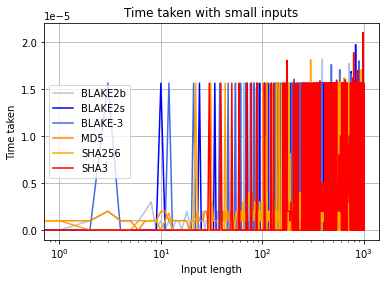

In [23]:
# Short
all_times_s = []
for i in range(len(methods)):
    method = methods[i]
    avg_times = []

    for input_len in input_lengths_short:
        avg_times.append(timeit(method, test_vector[:input_len], runs=1000))
    all_times_s.append(avg_times)
    
plt.clf()
plt.plot(input_lengths_short,  all_times_s[0], label='BLAKE2b', color='lightsteelblue', linestyle="-")

plt.plot(input_lengths_short,  all_times_s[1], label='BLAKE2s', color='blue',            linestyle="-")

plt.plot(input_lengths_short,  all_times_s[5], label='BLAKE-3',  color='royalblue',      linestyle="-")

plt.plot(input_lengths_short,  all_times_s[2], label='MD5',     color='darkorange',     linestyle="-")

plt.plot(input_lengths_short,  all_times_s[3], label='SHA256',  color='orange',         linestyle="-")

plt.plot(input_lengths_short,  all_times_s[4], label='SHA3',    color='red',          linestyle="-")


plt.xlabel('Input length')
plt.ylabel('Time taken')
plt.xscale('log')
plt.grid()
plt.legend()
plt.title('Time taken with small inputs')
plt.show()

<md5 HASH object @ 0x00000261F84E7830>
<sha256 HASH object @ 0x00000261F84E7990>


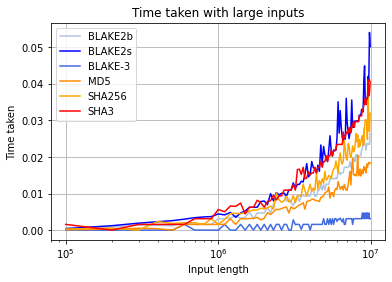

In [24]:
# Long
all_times_l = []
for i in range(len(methods)):
    method = methods[i]
    print(method)
    avg_times = []
    
    input_len_prev=0
    tv = b''
    for input_len in input_lengths_long:
        tv += test_vector[input_len_prev:input_len]
        input_len_prev = input_len
        avg_times.append(timeit(method, tv))
        
    all_times_l.append(avg_times)


plt.plot(input_lengths_long,  all_times_l[0], label='BLAKE2b', color='lightsteelblue', linestyle="-")

plt.plot(input_lengths_long,  all_times_l[1], label='BLAKE2s', color='blue',            linestyle="-")

plt.plot(input_lengths_long,  all_times_l[5], label='BLAKE-3',  color='royalblue',      linestyle="-")

plt.plot(input_lengths_long,  all_times_l[2], label='MD5',     color='darkorange',     linestyle="-")

plt.plot(input_lengths_long,  all_times_l[3], label='SHA256',  color='orange',         linestyle="-")

plt.plot(input_lengths_long,  all_times_l[4], label='SHA3',    color='red',          linestyle="-")



plt.xlabel('Input length')
plt.ylabel('Time taken')
plt.xscale('log')
plt.grid()
plt.legend()
plt.title('Time taken with large inputs')
plt.show()

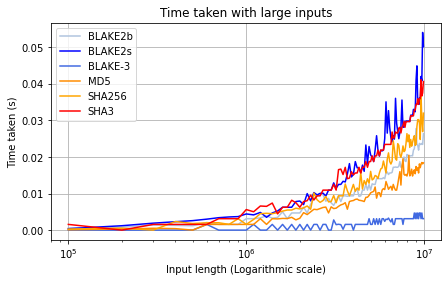

In [46]:
plt.rcParams['figure.figsize'] = [7, 4]


plt.plot(input_lengths_long,  all_times_l[0], label='BLAKE2b', color='lightsteelblue', linestyle="-")
plt.plot(input_lengths_long,  all_times_l[1], label='BLAKE2s', color='blue',            linestyle="-")
plt.plot(input_lengths_long,  all_times_l[5], label='BLAKE-3',  color='royalblue',      linestyle="-")
plt.plot(input_lengths_long,  all_times_l[2], label='MD5',     color='darkorange',     linestyle="-")
plt.plot(input_lengths_long,  all_times_l[3], label='SHA256',  color='orange',         linestyle="-")
plt.plot(input_lengths_long,  all_times_l[4], label='SHA3',    color='red',          linestyle="-")

plt.xlabel('Input length (Logarithmic scale)')
plt.ylabel('Time taken (s)')
plt.xscale('log')
plt.grid()
plt.legend()
plt.title('Time taken with large inputs')
plt.show()

In [25]:
method = BLAKE()
B_avg_times_s = []

for input_len in input_lengths_short:
    B_avg_times_s.append(timeit(method, test_vector[:input_len], runs=10))   

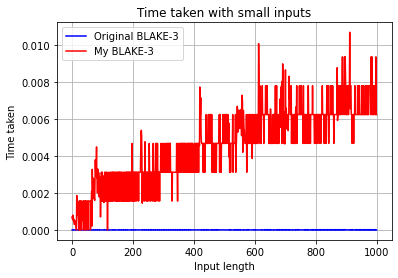

In [26]:
plt.clf()

plt.plot(input_lengths_short,  all_times_s[5], label='Original BLAKE-3',  color='blue',      linestyle="-")
plt.plot(input_lengths_short,  B_avg_times_s, label='My BLAKE-3',  color='red',      linestyle="-")



plt.xlabel('Input length')
plt.ylabel('Time taken')
#plt.xscale('log')
plt.grid()
plt.legend()
plt.title('Time taken with small inputs')
plt.show()

In [27]:
method = BLAKE()
B_avg_times_l = []
long_inputs_taken = 10
for input_len in input_lengths_long[:long_inputs_taken]:
    B_avg_times_l.append(timeit(method, test_vector[:input_len], runs=10))


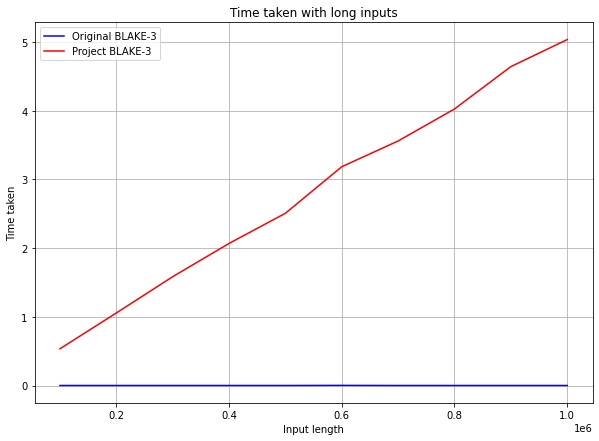

In [45]:
plt.clf()

plt.plot(input_lengths_long[:long_inputs_taken],  all_times_l[5][:long_inputs_taken], label='Original BLAKE-3',  color='blue',      linestyle="-")
plt.plot(input_lengths_long[:long_inputs_taken],  B_avg_times_l, label='Project BLAKE-3',  color='red',      linestyle="-")



plt.xlabel('Input length')
plt.ylabel('Time taken')
#plt.xscale('log')
plt.grid()
plt.legend()
plt.title('Time taken with long inputs')
plt.show()

In [29]:
np.average(B_avg_times_s)/np.average(all_times_s[5])

1757.5004790621601

In [30]:
np.average(B_avg_times_l)/np.average(all_times_l[5][:long_inputs_taken])

18045.009825910496

In [47]:
average_short = [np.format_float_positional(np.average(all_times_s[i]), precision = 10) for i in range(len(methods))]
names = ["BLAKE2b", "BLAKE2s", "MD5", "sha256", "sha3", "BLAKE3"]
print("Time (s)      -  Algorithm")
for i in range(6):
    print( average_short[i], " - ", names[i], ) 
print( np.format_float_positional(np.average(B_avg_times_s), precision = 10), " -  Project BLAKE3")

Time (s)      -  Algorithm
0.0000026  -  BLAKE2b
0.0000030596  -  BLAKE2s
0.0000019932  -  MD5
0.0000026333  -  sha256
0.0000031135  -  sha3
0.0000025966  -  BLAKE3
0.0045635849  -  Project BLAKE3


In [35]:
average_long = [np.format_float_positional(np.average(all_times_l[i]), precision = 5) for i in range(len(methods))]

print("Time (s)      -  Algorithm")
for i in range(6):
    print( average_long[i], " - ", names[i], ) 
print( np.format_float_positional(np.average(B_avg_times_l), precision = 8), " -  Project BLAKE3")

Time (s)      -  Algorithm
0.01259  -  BLAKE2b
0.02015  -  BLAKE2s
0.00952  -  MD5
0.01476  -  sha256
0.01911  -  sha3
0.002  -  BLAKE3
2.8197479  -  Project BLAKE3
